In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

from VQLS import  estimateNorm
from LSSVM import predict, accuracy, linearKernel
import LSSVM
from VQLSSVM import VQLSSVM

In [2]:
shots: int = 10000
gamma: float = 0.01 # regularization parameter
testSize: float = 0.2
subsetSize: int = 7
classToFilterOut: int = 2

In [3]:
vqlssvm: VQLSSVM = VQLSSVM(gamma, shots)

In [4]:
# X, y = datasets.make_classification( # dummy data
#     n_samples=50, n_features=2, n_informative=2, n_redundant=0, random_state=45
# )
X,y = datasets.load_iris(return_X_y=True)
X = X[y!=classToFilterOut]
y = y[y!=classToFilterOut]

y: np.array = np.where(y == 0, -1, 1)
xTrain, xTest, yTrain, yTest = train_test_split(
    X, y, test_size=testSize, random_state=42
)
subsetIndices  = np.random.choice(np.arange(xTrain.shape[0]), subsetSize, replace=False)
xSubset = np.array([xTrain[i] for i in subsetIndices])
ySubset = np.array([yTrain[i] for i in subsetIndices])

LS-SVM Matrix: [[  0.     1.     1.     1.     1.     1.     1.     1.  ]
 [  1.   138.85  36.37  36.84  37.31  42.26  39.56  52.69]
 [  1.    36.37 134.06  34.49  34.92  39.31  37.05  49.02]
 [  1.    36.84  34.49 135.01  35.43  40.31  37.51  50.27]
 [  1.    37.31  34.92  35.43 135.88  40.83  37.97  50.92]
 [  1.    42.26  39.31  40.31  40.83 154.19  42.79  67.25]
 [  1.    39.56  37.05  37.51  37.97  42.79 140.31  53.35]
 [  1.    52.69  49.02  50.27  50.92  67.25  53.35 183.48]]
['III', 'IIX', 'IIZ', 'IXI', 'IXX', 'IXZ', 'IYY', 'IZI', 'IZX', 'IZZ',
 'XII', 'XIX', 'XIZ', 'XXI', 'XXX', 'XXZ', 'XYY', 'XZI', 'XZX', 'XZZ',
 'YIY', 'YXY', 'YYI', 'YYX', 'YYZ', 'YZY', 'ZII', 'ZIX', 'ZIZ', 'ZXI',
 'ZXX', 'ZXZ', 'ZYY', 'ZZI', 'ZZX', 'ZZZ']
Pauli matrix coeffitients [(127.7225+0j), (32.417500000000004+0j), (-25.159999999999997+0j), (35.765+0j), (32.769999999999996+0j), (-16.28+0j), (6.809999999999999+0j), (-20.492500000000007+0j), (-11.5025+0j), (-14.129999999999995+0j), (32.644999999999996+0

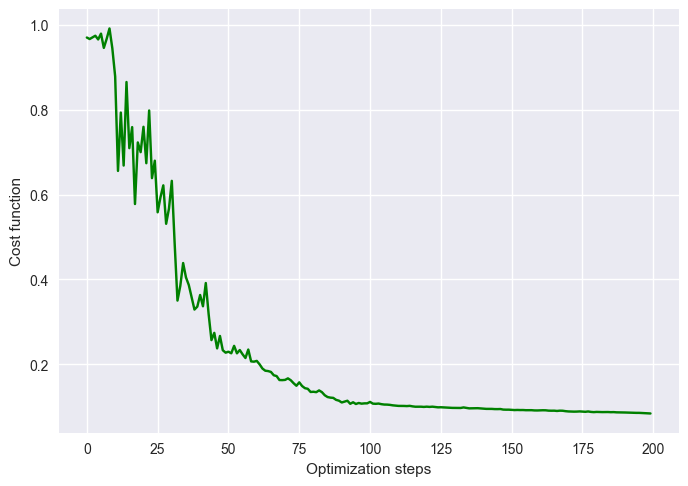

In [5]:
vqlssvm.train(xSubset, ySubset, quantumSimulation=False, verbose=True, iterations = 200)

vqlssvm.plotCost()

In [6]:
print(vqlssvm.predict(xTest))

[ 0.08891567+0.j  0.03469016+0.j  0.06002955+0.j -0.17165898+0.j
 -0.17040656+0.j -0.19130192+0.j -0.2141844 +0.j  0.01230636+0.j
 -0.2125925 +0.j -0.20170168+0.j -0.21069943+0.j -0.16279558+0.j
  0.04341921+0.j -0.2396411 +0.j  0.0516171 +0.j -0.20097281+0.j
  0.02801318+0.j  0.047142  +0.j -0.17642725+0.j -0.19827225+0.j]


In [7]:
 print("Accuracy:",vqlssvm.accuracy(xTest, yTest))

Accuracy: 1.0


LS-SVM Matrix: [[  0.     1.     1.     1.     1.     1.     1.     1.  ]
 [  1.   138.85  36.37  36.84  37.31  42.26  39.56  52.69]
 [  1.    36.37 134.06  34.49  34.92  39.31  37.05  49.02]
 [  1.    36.84  34.49 135.01  35.43  40.31  37.51  50.27]
 [  1.    37.31  34.92  35.43 135.88  40.83  37.97  50.92]
 [  1.    42.26  39.31  40.31  40.83 154.19  42.79  67.25]
 [  1.    39.56  37.05  37.51  37.97  42.79 140.31  53.35]
 [  1.    52.69  49.02  50.27  50.92  67.25  53.35 183.48]]
['III', 'IIX', 'IIZ', 'IXI', 'IXX', 'IXZ', 'IYY', 'IZI', 'IZX', 'IZZ',
 'XII', 'XIX', 'XIZ', 'XXI', 'XXX', 'XXZ', 'XYY', 'XZI', 'XZX', 'XZZ',
 'YIY', 'YXY', 'YYI', 'YYX', 'YYZ', 'YZY', 'ZII', 'ZIX', 'ZIZ', 'ZXI',
 'ZXX', 'ZXZ', 'ZYY', 'ZZI', 'ZZX', 'ZZZ']
Pauli matrix coeffitients [(127.7225+0j), (32.417500000000004+0j), (-25.159999999999997+0j), (35.765+0j), (32.769999999999996+0j), (-16.28+0j), (6.809999999999999+0j), (-20.492500000000007+0j), (-11.5025+0j), (-14.129999999999995+0j), (32.644999999999996+0

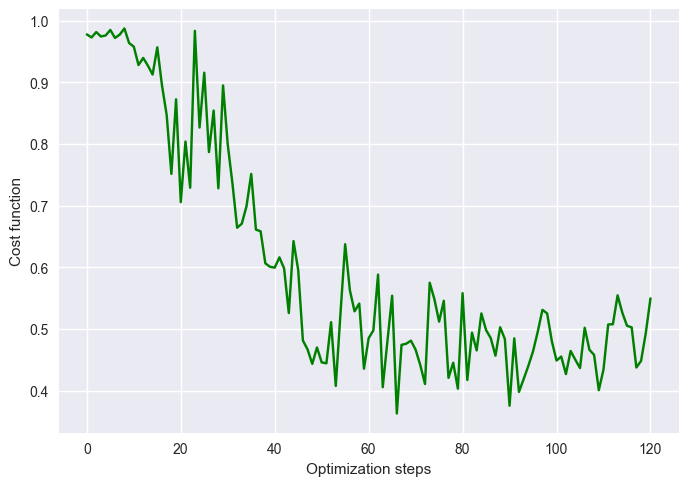

In [8]:
vqlssvm.train(xSubset, ySubset, quantumSimulation=True, verbose=True, iterations = 200)

vqlssvm.plotCost()

In [9]:
print("Predictions: ", vqlssvm.predict(xTest))
print("Accuracy: ", vqlssvm.accuracy(xTest, yTest))

Predictions:  [ 0.24895096+0.j  0.18724893+0.j  0.19856765+0.j -0.07832578+0.j
 -0.09093381+0.j -0.10445901+0.j -0.14587324+0.j  0.16032954+0.j
 -0.13137536+0.j -0.11925735+0.j -0.1269629 +0.j -0.06888587+0.j
  0.19842319+0.j -0.17357047+0.j  0.20171931+0.j -0.12256834+0.j
  0.19073028+0.j  0.20378769+0.j -0.08179003+0.j -0.10948645+0.j]
Accuracy:  1.0
